In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from relativeEfficiencyLib import *
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
import time
%matplotlib inline

In [ ]:
def createMinConstAlpha():
    
    Alpha = []
    for e in np.linspace(1, 5, 11):
        
        tmp = np.linspace( e, e + 1, 10, endpoint=False)
        tmp2 = np.concatenate([[1],np.linspace( e, e + 1, 10, endpoint=False)[1:]])
        
        tmpMean = np.mean(tmp) - np.mean(tmp2)
        
        tmp2[1:] += tmpMean*(np.float(len(tmp))/len(tmp2[1:]) )
        
        Alpha.append(tmp2)
        
    return Alpha

In [ ]:
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 22})

In [ ]:
def ratioCorrect(n, ratio, threshold = 3.5):
    
    df = pd.DataFrame({'n':np.tile(n, ratio.shape[0]), 'ratio':ratio.flatten()})
    dfr = df[np.abs(df["ratio"]) < threshold]
    md = smf.mixedlm("ratio ~ n",dfr, groups=dfr["n"])
    mdf = md.fit()
    dfr = dfr.assign(fitted = mdf.params[0] + mdf.params[1] * dfr["n"])
    
    return [dfr, np.abs(mdf.params[1]), mdf]

In [ ]:
def ratioCorrectOLS(n, ratio, threshold = 3.5):
    
    df = pd.DataFrame({'n':np.tile(n, ratio.shape[0]), 'ratio':ratio.flatten()})
    dfr = df[np.abs(df["ratio"]) < threshold]
    md = smf.ols("ratio ~ n",dfr)
    mdf = md.fit()
    dfr = dfr.assign(fitted = mdf.params[0] + mdf.params[1] * dfr["n"])
    
    return [dfr, np.abs(mdf.params[1])]

In [ ]:
outAlphaMinVar = compRelEffVarShapeVarMin(ALPHA=
                                          [np.linspace( e, e + 1, 10, endpoint=False) for e in np.linspace(1, 5, 11)])

In [ ]:
fig, ax = plt.subplots(figsize = [20, 10])
nValues = np.linspace(1, 5, 11, endpoint= True)
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.jet
table = np.zeros([len(outAlphaMinVar), 3])
for i in range(len(outAlphaMinVar)):
    n, ratio, shape, mu, c = outAlphaMinVar[i]
    
    out = ratioCorrectOLS(n, ratio)
    rLine = out[0]
    r = out[1]
    ax.scatter(rLine["n"], rLine["ratio"], alpha = .1, s = 5, color=colormap(normalize(nValues[i])))
    ax.plot(rLine["n"], rLine["fitted"], alpha = .5, lw = .5, color=colormap(normalize(nValues[i])),
            label = "".join(["c = ", np.str("{:.0e}".format(c))," ,mu = ", np.str("{:.2e}".format(mu))]))
    
    table[i,:] = shape[0], mu, r
    
ax.set_xlim([0, 2000])
ax.set_ylim([-3.5, 0])
ax.set_xlabel(r'n', fontsize = 30)
ax.set_ylabel(r"$ log(\Lambda)$", fontsize = 30)
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
cbar = fig.colorbar(scalarmappaple)
cbar.set_label(r"$ \alpha_{min} $", fontsize = 30)

In [ ]:
fig.savefig("./plots.v.1.0/alphaMinVar.pdf")

In [ ]:
outAlphaMinConst = compRelEffVarShapeVarMin(ALPHA= createMinConstAlpha())

In [ ]:
fig, ax = plt.subplots(figsize = [20, 10])
nValues = np.array([np.round(np.mean(outAlphaMinConst[i][2]), 2) for i in range(len(outAlphaMinConst))])
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.jet
table = np.zeros([len(outAlphaMinConst), 3])
for i in range(len(outAlphaMinConst)):
    n, ratio, shape, mu, c = outAlphaMinConst[i]
    
    out = ratioCorrectOLS(n, ratio, threshold=3)
    rLine = out[0]
    r = out[1]
    ax.scatter(rLine["n"], rLine["ratio"], alpha = .1, s = 5, color=colormap(normalize(nValues[i])))
    ax.plot(rLine["n"], rLine["fitted"], alpha = .5, lw = .5, color=colormap(normalize(nValues[i])),
            label = "".join(["c = ", np.str("{:.0e}".format(c))," ,mu = ", np.str("{:.2e}".format(mu))]))
    
    table[i,:] = np.mean(shape), mu, r

ax.set_xlim([0, 2000])
ax.set_ylim([-3, 0])
ax.set_xlabel(r'n', fontsize = 30)
ax.set_ylabel(r"$ log(\Lambda)$", fontsize = 30)
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
cbar = fig.colorbar(scalarmappaple)
cbar.set_label(r"$\bar{\alpha}$", fontsize = 30)

In [ ]:
fig.savefig("./plots.v.1.0/alphaMinConst.pdf")

In [ ]:
table

In [ ]:
import pickle as pkl
pkl.dump(outAlphaMinConst, open("./simData/ourAlphaMinConst.pkl", "wb"))
pkl.dump(outAlphaMinVar, open("./simData/ourAlphaMinVar.pkl", "wb"))

In [ ]:
n, ratio, shape, mu, c = outAlphaMinConst[0]
ss =ratioCorrect(n, ratio)

In [ ]:
model.summary()

In [104]:
def timeIt(shape = np.linspace( 1, 2, 10, endpoint=False), 
                    n = np.linspace(2, 20000, 1000).astype(np.int), kappa = .01, k = 5, c = 100, verbose = False):
    
    print(shape)
    
    times = np.zeros((k, len(n), 2))
    for i in range(len(n)):
        
        tmp = CMC(shape = shape, n = n[i], c = c)
        
        for j in range(k):
            
            tmp.take_sample()
            s = time.time()
            tmp.mc()
            e1 = time.time()
            tmp.cmc()
            e2 = time.time()
            times[j, i, :] = [e1-s, e2-e1]
    
    return(n, times)

In [176]:
times160 = timeIt(n = np.linspace(5000,400000,159, endpoint=True).astype(np.int))

[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9]


In [182]:
n = np.linspace(5000,400000,159, endpoint=True)
times_df = pd.DataFrame(times160[1].reshape([len(n)*5, 2]))
times_df.columns = ["MC", "CMC"]
times_df["n"] = np.tile(times160[0], 5)

In [183]:
times_melt = times_df.melt(id_vars="n", value_vars=["MC", "CMC"])

In [184]:
spl = UnivariateSpline(times160[0],
                       np.log(np.mean(times160[1], 0)[:,1]) - np.log(np.mean(times160[1], 0)[:,0]))
xs = np.linspace(times160[0][0], times160[0][-1], 1000)

In [188]:
times_df = times_df.assign(logRatio = np.log(times_df["CMC"]) - np.log(times_df["MC"]))
md = smf.ols("logRatio ~ n",times_df.loc[times_df.loc[:,"n"] > 100000,:])
mdf = md.fit()
times_df = times_df.assign(fitted = mdf.params[0] + mdf.params[1] * times_df["n"])
mdf.params[1]
mdf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logRatio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.06869
Date:                Sat, 26 Jan 2019   Prob (F-statistic):              0.793
Time:                        19:26:34   Log-Likelihood:                 704.85
No. Observations:                 600   AIC:                            -1406.
Df Residuals:                     598   BIC:                            -1397.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.5155      0.009    481.413      0.000       4.497       4.534
n           9.251e-09   3.53e-08      0.262      0.793   -6.01e-08    7.86e-08
==============================================================================
Omnibus:                       36.859   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.421
Skew:                          -0.343   Prob(JB):                     2.09e-18
Kurtosis:                       4.669   Cond. No.                     8.16e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [225]:
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 22})

(5000, 400000)

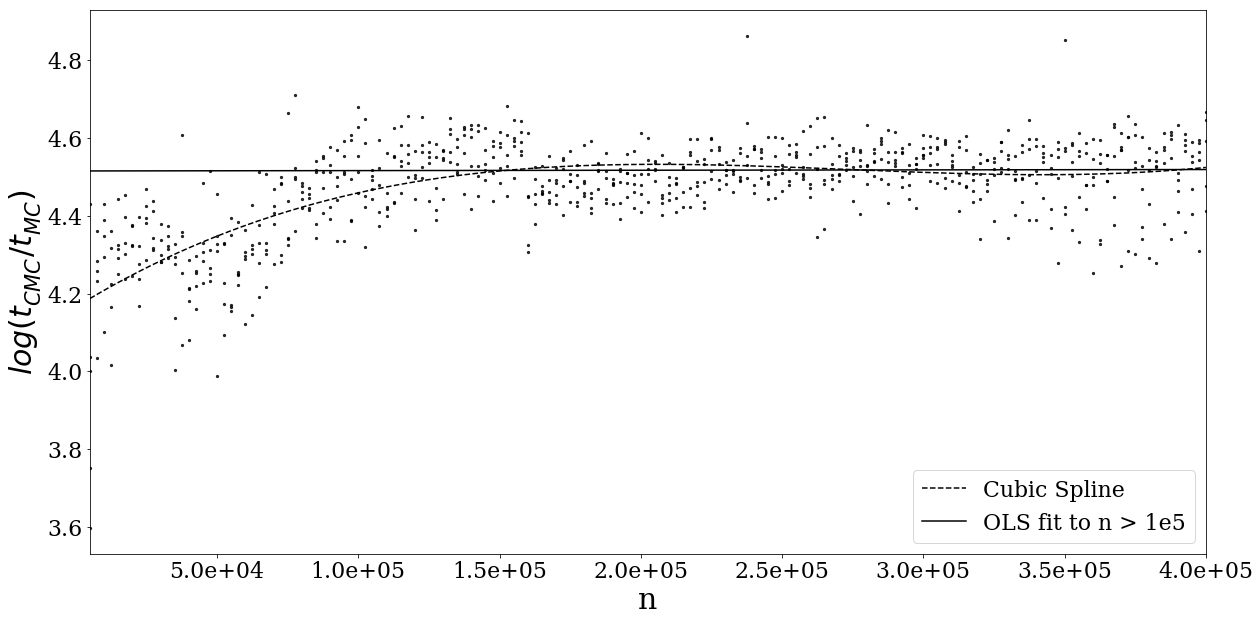

In [226]:
f, ax = plt.subplots(figsize = [20, 10])
ax.scatter(times_df["n"], y = np.log(times_df["CMC"]) - np.log(times_df["MC"]), c = "k", alpha = .8, s = 5)
#ax.plot(times160[0],np.log(np.mean(times160[1], 0)[:,1]) - np.log(np.mean(times160[1], 0)[:,0]),
#        alpha = 1, label = "mean")
ax.plot(xs, spl(xs),c = "k", ls = "dashed", label = "Cubic Spline")
ax.plot(times_df["n"], times_df["fitted"], c = "k", label = "OLS fit to n > 1e5")
ax.set_xlabel(r'n', fontsize = 30)
ax.set_ylabel(r"$ log(t_{CMC}/t_{MC})$", fontsize = 30)
ax.legend(loc = 4)
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1e'))
ax.set_xlim([5000, 400000])

In [227]:
f.savefig("./plots.v.1.0/complexity.pdf")

In [87]:
np.log(np.mean(times[1], 0)[1]) - np.log(np.mean(times[1], 0)[0])

array([0.00587373, 0.15278331])

In [90]:
np.mean(times[1], 0)[:,1]

array([0.00221841, 0.00258461, 0.00294447, 0.00366333, 0.00383991,
       0.00424198, 0.00466461, 0.00527594, 0.0056018 , 0.00582927,
       0.00617845, 0.00706613, 0.00724617, 0.00743279, 0.00783445,
       0.00822489, 0.00869793, 0.00940874, 0.00951387, 0.01000428,
       0.01024333, 0.01092145, 0.01111697, 0.011634  , 0.01226275,
       0.0124136 , 0.0128121 , 0.01332309, 0.0143939 , 0.01478788,
       0.01481504, 0.01543914, 0.01671559, 0.01732965, 0.01677997,
       0.0172138 , 0.01804465, 0.018691  , 0.01857597, 0.01904343])

In [126]:
from scipy.interpolate import UnivariateSpline